📥 获取数据: 300750 ...
[买入] 2023-02-17 价格:220.25 (触及下轨+超卖)
[卖出] 2023-03-14 价格:201.94 盈亏:-8.31% | 原因: 止损(-8%)
[买入] 2023-03-17 价格:195.69 (触及下轨+超卖)
[卖出] 2023-10-13 价格:178.81 盈亏:-8.63% | 原因: 止损(-8%)
[买入] 2023-10-16 价格:172.97 (触及下轨+超卖)
[卖出] 2023-11-27 价格:158.91 盈亏:-8.13% | 原因: 止损(-8%)
[买入] 2023-12-18 价格:135.18 (触及下轨+超卖)
[卖出] 2024-03-12 价格:174.05 盈亏:28.75% | 原因: 乖离率过大(偏离中轨15%)
[买入] 2024-06-07 价格:186.44 (触及下轨+超卖)
[卖出] 2024-07-01 价格:169.31 盈亏:-9.19% | 原因: 止损(-8%)
[买入] 2025-01-07 价格:242.69 (触及下轨+超卖)
[卖出] 2025-04-07 价格:209.68 盈亏:-13.60% | 原因: 止损(-8%)
[买入] 2025-04-08 价格:213.51 (触及下轨+超卖)
[卖出] 2025-09-15 价格:354.70 盈亏:66.13% | 原因: 乖离率过大(偏离中轨15%)
[买入] 2026-01-13 价格:359.00 (触及下轨+超卖)


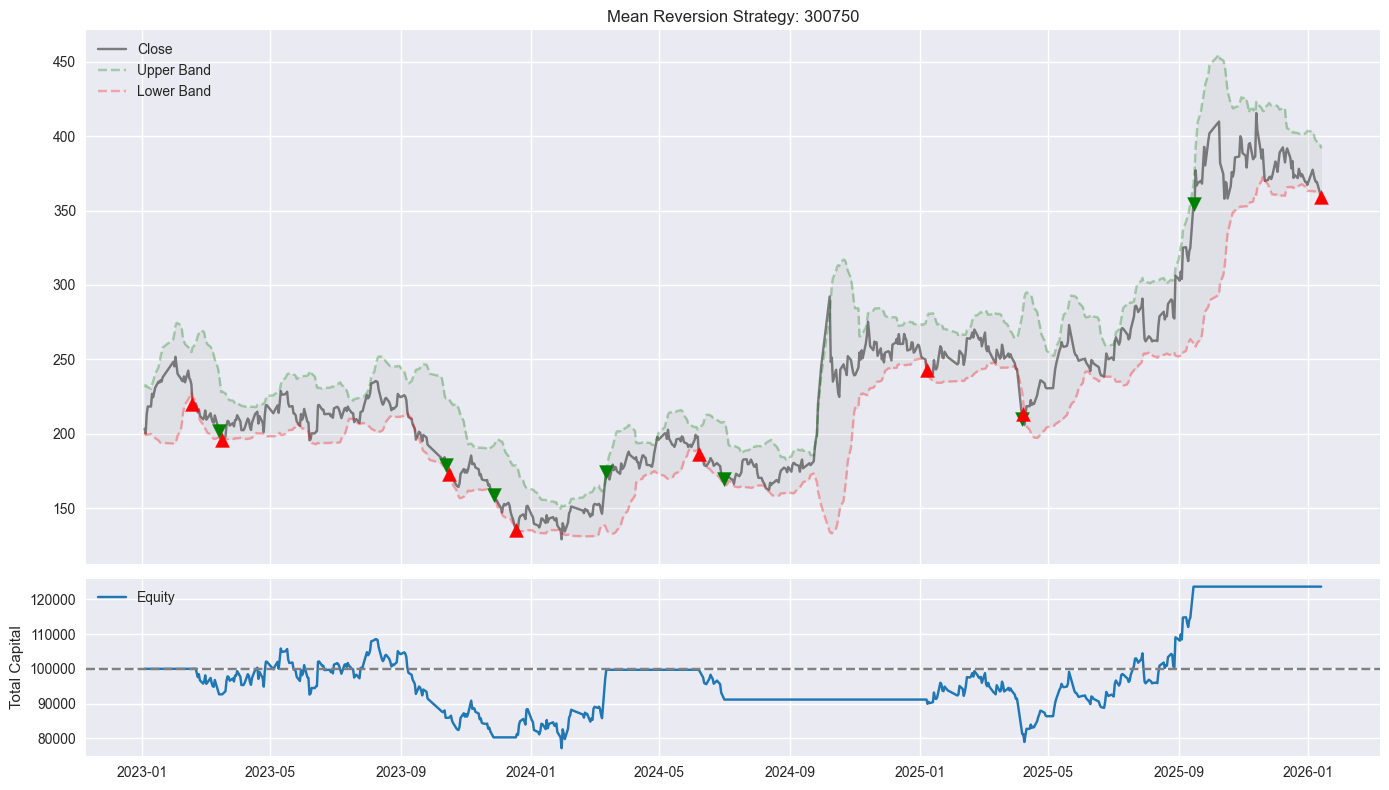

In [2]:
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

# 配置
plt.style.use('seaborn-v0_8')
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

class SimpleReversionStrategy:
    def __init__(self, symbol, start_date):
        self.symbol = symbol
        self.start_date = start_date
        self.capital = 100000
    
    def fetch_data(self):
        # 多取一些数据用于计算指标
        fetch_start = (pd.to_datetime(self.start_date) - timedelta(days=100)).strftime('%Y%m%d')
        today = datetime.now().strftime('%Y%m%d')
        
        print(f"📥 获取数据: {self.symbol} ...")
        df = ak.stock_zh_a_hist(symbol=self.symbol, period="daily", start_date=fetch_start, end_date=today, adjust="qfq")
        
        if df.empty: return pd.DataFrame()
        
        df = df.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', '最高':'high', '最低':'low', '成交量':'volume'})
        df['date'] = pd.to_datetime(df['date'])
        
        # === 核心指标计算 ===
        
        # 1. 布林带 (Bollinger Bands) - 描述"高低"的空间
        # 中轨：20日均线
        df['mid'] = df['close'].rolling(window=20).mean()
        # 标准差
        df['std'] = df['close'].rolling(window=20).std()
        # 上轨 (压力位)：中轨 + 2倍标准差
        df['upper'] = df['mid'] + 3 * df['std']
        # 下轨 (支撑位)：中轨 - 2倍标准差
        df['lower'] = df['mid'] - 2 * df['std']
        
        # 2. RSI - 描述"高低"的速度/情绪
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        return df.dropna()

    def run_backtest(self):
        df = self.fetch_data()
        if df.empty: return

        # 截取回测段
        mask = df['date'] >= pd.to_datetime(self.start_date)
        test_data = df[mask].copy()
        
        position = 0
        cash = self.capital
        equity_curve = []
        trades = [] # 记录交易点
        
        # 遍历回测
        for i, row in test_data.iterrows():
            current_price = row['close']
            date = row['date']
            
            # === 1. 判断低位 (买入逻辑) ===
            # 简单粗暴：跌破布林下轨，且 RSI < 30 (超卖)，视为"极低位"，捡便宜
            if position == 0:
                if row['close'] < row['lower'] and row['rsi'] < 40:
                    position = int(cash / current_price / 100) * 100
                    cash -= position * current_price
                    trades.append({'date': date, 'type': 'BUY', 'price': current_price})
                    print(f"[买入] {date.date()} 价格:{current_price:.2f} (触及下轨+超卖)")

            # === 2. 判断高位 (卖出逻辑) ===
            # 这是你需要多方考虑的地方
            elif position > 0:
                is_high = False
                sell_reason = ""
                
                # 条件 A: 触及布林上轨 (统计学高位)
                # 仅触及上轨不一定卖，可能正处于主升浪，需要结合 RSI 判断是否过热
                if row['close'] > row['upper']:
                    if row['rsi'] > 75: # 既破上轨，RSI又超买 -> 此时是真高位
                        is_high = True
                        sell_reason = "触及上轨且RSI超买"
                    
                # 条件 B: 乖离率过大 (防止单边暴涨后的回撤)
                # 比如 价格 超过 中轨 15%
                if (row['close'] - row['mid']) / row['mid'] > 0.15:
                    is_high = True
                    sell_reason = "乖离率过大(偏离中轨15%)"
                    
                # 条件 C: 绝对止损 (防止判断失误，单边下跌)
                last_buy = trades[-1]['price']
                if current_price < last_buy * 0.92:
                    is_high = True # 这里的"高"是指相对于未来的更低点，赶紧跑
                    sell_reason = "止损(-8%)"

                if is_high:
                    cash += position * current_price
                    pnl = (current_price - last_buy) / last_buy * 100
                    trades.append({'date': date, 'type': 'SELL', 'price': current_price})
                    print(f"[卖出] {date.date()} 价格:{current_price:.2f} 盈亏:{pnl:.2f}% | 原因: {sell_reason}")
                    position = 0
            
            # 记录净值
            total_asset = cash + (position * current_price)
            equity_curve.append(total_asset)
            
        test_data['equity'] = equity_curve
        self.plot_results(test_data, trades)

    def plot_results(self, df, trades):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        
        # 上图：K线 + 布林带
        ax1.plot(df['date'], df['close'], label='Close', color='#333', alpha=0.6)
        ax1.plot(df['date'], df['upper'], label='Upper Band', color='green', linestyle='--', alpha=0.3)
        ax1.plot(df['date'], df['lower'], label='Lower Band', color='red', linestyle='--', alpha=0.3)
        ax1.fill_between(df['date'], df['upper'], df['lower'], color='gray', alpha=0.1)
        
        # 标记买卖点
        for t in trades:
            if t['type'] == 'BUY':
                ax1.scatter(t['date'], t['price'], marker='^', color='red', s=100, zorder=5)
            else:
                ax1.scatter(t['date'], t['price'], marker='v', color='green', s=100, zorder=5)
                
        ax1.set_title(f'Mean Reversion Strategy: {self.symbol}')
        ax1.legend()
        
        # 下图：资金曲线
        ax2.plot(df['date'], df['equity'], color='#1f77b4', label='Equity')
        ax2.axhline(self.capital, color='gray', linestyle='--')
        ax2.set_ylabel('Total Capital')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # 找一个震荡比较明显的股票测试，比如 600519 茅台，或者指数 ETF
    # 这里用 300750 宁德时代 试试
    strategy = SimpleReversionStrategy("300750", "2023-01-01")
    strategy.run_backtest()



==================== 正在分析: 梅花生物 - 食品/调味品 (600873) ====================
💰 [止盈1] 2025-03-18 @ 9.74 (回归中轨, 减半)
💰 [止盈1] 2025-03-19 @ 9.99 (回归中轨, 减半)
💰 [止盈1] 2025-03-20 @ 9.83 (回归中轨, 减半)
💰 [止盈1] 2025-03-21 @ 9.88 (回归中轨, 减半)
💰 [止盈1] 2025-03-24 @ 10.10 (回归中轨, 减半)
💰 [止盈1] 2025-03-25 @ 10.05 (回归中轨, 减半)
💰 [止盈1] 2025-09-08 @ 11.18 (回归中轨, 减半)
💰 [止盈1] 2025-09-09 @ 11.26 (回归中轨, 减半)
💰 [止盈1] 2025-09-10 @ 11.16 (回归中轨, 减半)
💰 [止盈1] 2025-09-11 @ 11.17 (回归中轨, 减半)
💰 [止盈1] 2025-10-30 @ 11.08 (回归中轨, 减半)
💰 [止盈1] 2025-10-31 @ 11.17 (回归中轨, 减半)
💰 [止盈1] 2025-11-03 @ 11.37 (回归中轨, 减半)
💰 [止盈1] 2025-11-04 @ 11.44 (回归中轨, 减半)
💰 [止盈1] 2025-11-05 @ 11.28 (回归中轨, 减半)
💰 [止盈1] 2025-11-06 @ 11.55 (回归中轨, 减半)


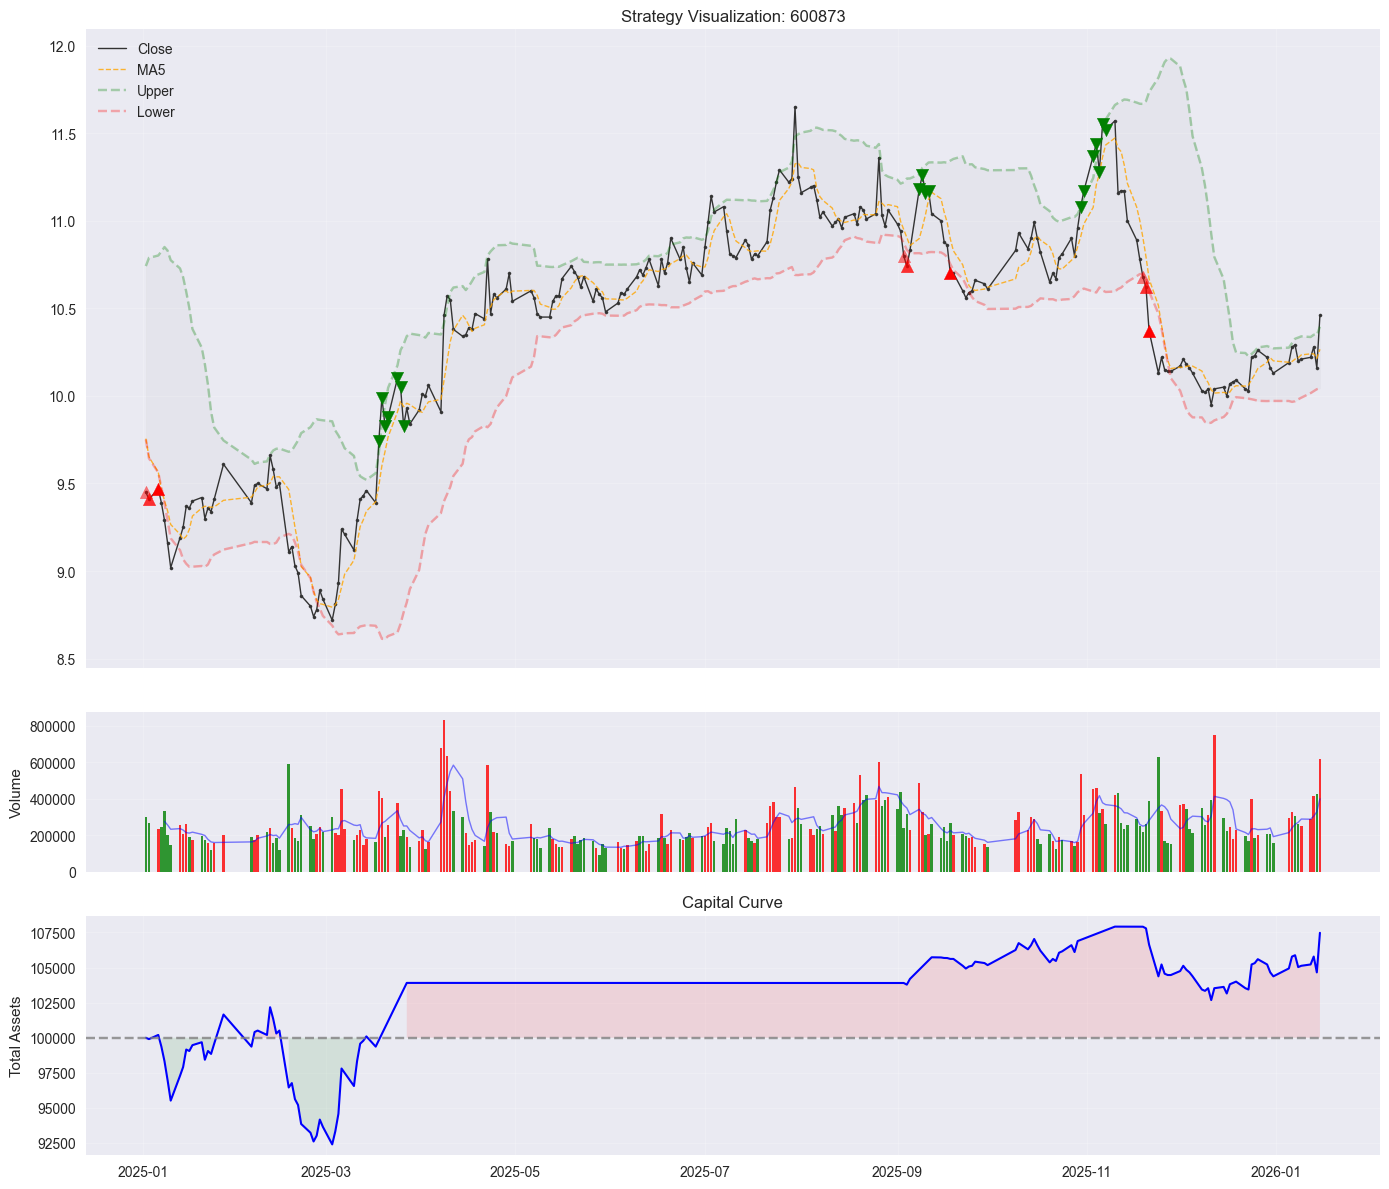

In [17]:

# ==========================================
# 策略逻辑 (Strategy Logic)
# ==========================================
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

# 配置
plt.style.use('seaborn-v0_8')
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# ==========================================
# 仓位管理器 (Position Manager)
# ==========================================
class PositionManager:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.cash = initial_capital
        self.shares = 0
        self.avg_cost = 0.0
        self.history = []

    def buy(self, date, price, pct_of_capital):
        target_amount = self.initial_capital * pct_of_capital
        actual_amount = min(self.cash, target_amount)
        if actual_amount < 1000: return False

        shares_to_buy = int(actual_amount / price / 100) * 100
        if shares_to_buy == 0: return False

        cost = shares_to_buy * price
        fee = max(5, cost * 0.0003)
        self.cash -= (cost + fee)
        
        total_cost_old = self.shares * self.avg_cost
        self.shares += shares_to_buy
        self.avg_cost = (total_cost_old + cost) / self.shares
        
        self.history.append({
            'date': date, 'action': 'BUY', 'price': price, 
            'shares': shares_to_buy, 'avg_cost': self.avg_cost,
            'pct': f"{pct_of_capital*100:.0f}%"
        })
        return True

    def sell(self, date, price, fraction):
        if self.shares == 0: return False
        
        shares_to_sell = int(self.shares * fraction / 100) * 100
        # 如果剩下不足100股或者要求全卖，则卖光
        if fraction == 1.0 or (self.shares - shares_to_sell < 100):
            shares_to_sell = self.shares
        
        if shares_to_sell == 0: return False

        revenue = shares_to_sell * price
        fee = max(5, revenue * 0.0013)
        pnl_pct = (price - self.avg_cost) / self.avg_cost * 100
        
        self.cash += (revenue - fee)
        self.shares -= shares_to_sell
        
        if self.shares == 0: self.avg_cost = 0
        
        self.history.append({
            'date': date, 'action': 'SELL', 'price': price, 
            'shares': shares_to_sell, 'pnl': pnl_pct,
            'reason': f"卖{fraction*100:.0f}%"
        })
        return True

# ==========================================
# 策略逻辑
# ==========================================
class ScaleTradingStrategy:
    def __init__(self, symbol, start_date):
        self.symbol = symbol
        self.start_date = start_date
        self.pm = PositionManager(initial_capital=100000)
    
    def fetch_data(self):
        # print(f"📥 获取数据: {self.symbol} ...")
        # 多取一些数据用于预热指标
        start_dt = pd.to_datetime(self.start_date) - timedelta(days=100)
        
        try:
            df = ak.stock_zh_a_hist(symbol=self.symbol, period="daily", 
                                    start_date=start_dt.strftime('%Y%m%d'), adjust="qfq")
        except:
            return pd.DataFrame()

        if df.empty: return pd.DataFrame()
        
        df = df.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                                '最高':'high', '最低':'low', '成交量':'volume'})
        df['date'] = pd.to_datetime(df['date'])
        
        # --- 指标计算 ---
        # 1. 均线 (MA5用于趋势跟随，MA20用于中枢)
        df['ma5'] = df['close'].rolling(5).mean()  # [新增] 必须有MA5
        df['ma20'] = df['close'].rolling(20).mean()
        
        # 2. 布林带
        df['std'] = df['close'].rolling(20).std()
        df['upper'] = df['ma20'] + 2 * df['std'] # 标准是2.0，之前2.25可能太宽
        df['lower'] = df['ma20'] - 1.45 * df['std']
        
        # 3. RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        return df.fillna(0)

    def run(self):
        df = self.fetch_data()
        if df.empty: return

        mask = df['date'] >= pd.to_datetime(self.start_date)
        test_data = df[mask].reset_index(drop=True)
        
        equity_curve = []
        buy_stage = 0 
        
        # [新增] 上下文记录，用于记录一轮交易中的最高浮盈，服务于"保本逻辑"
        context = {'max_profit': 0}

        for i, row in test_data.iterrows():
            price = row['close']
            date = row['date']
            ma5 = row['ma5'] # 获取MA5

            # ==========================
            # 1. 买入逻辑 (混合模式)
            # ==========================
            
            # [扫尾逻辑]: 剩余极少仓位且盈利，自动清仓重置
            current_value = self.pm.shares * price
            if 0 < current_value < 2000 and price > self.pm.avg_cost:
                if self.pm.sell(date, price, 1.0):
                    buy_stage = 0
                    context['max_profit'] = 0 # 重置最大盈利记录
                    # print(f"🧹 [扫尾] {date.date()} @ {price:.2f} (零头清仓, 准备下一轮)")
                    continue 

            # [建仓 - 第一枪]
            if buy_stage == 0:
                if price < row['lower'] and row['rsi'] < 45:
                    if self.pm.buy(date, price, 0.20):
                        buy_stage = 1
                        context['max_profit'] = 0
                        # print(f"➕ [建仓] {date.date()} @ {price:.2f} (底仓20%)")

            # [补仓 - 第二/三枪]
            elif buy_stage < 3:
                # 触发条件 A: 成本摊低 (跌破均价 5% 或 10%)
                cost_threshold = 0.95 if buy_stage == 1 else 0.90
                is_cost_down = price < self.pm.avg_cost * cost_threshold
                
                # 触发条件 B: 技术面二次探底 (再次跌破下轨 + RSI低)
                is_tech_dip = (price < row['lower']) and (row['rsi'] < 40)
                
                if is_cost_down or is_tech_dip:
                    # 比例: 二仓加30%，三仓加50% (2-3-5模型)
                    pct = 0.30 if buy_stage == 1 else 0.50
                    reason = "摊低成本" if is_cost_down else "二次探底"
                    
                    if self.pm.buy(date, price, pct):
                        buy_stage += 1
                        # print(f"➕ [补仓-{reason}] {date.date()} @ {price:.2f} (加仓{pct*100:.0f}%)")

            # ==========================
            # 2. 卖出逻辑 (进阶版)
            # ==========================
            if self.pm.shares > 0:
                current_profit_pct = (price - self.pm.avg_cost) / self.pm.avg_cost
                
                # 更新本轮持仓的最高盈利记录
                context['max_profit'] = max(context['max_profit'], current_profit_pct)

                # [机制 A: 保本止损]
                # 如果曾经盈利超过 10%，绝不允许变成亏损
                # 一旦回落到 成本价*1.01 (留1%手续费空间)，强制离场
                if context['max_profit'] > 0.10 and price < self.pm.avg_cost * 1.01:
                    if self.pm.sell(date, price, 1.0):
                        buy_stage = 0
                        context['max_profit'] = 0
                        print(f"🛡️ [保本] {date.date()} @ {price:.2f} (盈利回吐保护, 离场)")
                        continue

                # [止盈 1]: 回归中轨 (MA20) -> 卖一半 (落袋为安)
                # 条件: 价格 > MA20 且 盈利 > 3%
                if price > row['ma20'] and buy_stage > 0:
                    if current_profit_pct > 0.03:
                        # 仅当没有执行过清仓动作时执行
                        if self.pm.sell(date, price, 0.5): 
                            
                            print(f"💰 [止盈1] {date.date()} @ {price:.2f} (回归中轨, 减半)")
                            continue

                # [止盈 2]: 趋势跟随 (Trend Follow) -> 清仓剩余
                # 逻辑: 只有当价格处于高位(>上轨) 且 跌破MA5(趋势转弱) 时才卖
                if price > row['upper']:
                    if price < ma5: # 关键点：跌破MA5才卖
                        if self.pm.sell(date, price, 1.0):
                            buy_stage = 0
                            context['max_profit'] = 0
                            print(f"📉 [止盈2] {date.date()} @ {price:.2f} (高位跌破MA5, 趋势结束清仓)")

                # [止盈 3]: 极度疯狂 (RSI > 80) -> 无论如何都要跑
                if row['rsi'] > 80:
                    if self.pm.sell(date, price, 1.0): 
                        buy_stage = 0
                        context['max_profit'] = 0
                        print(f"🚀 [清仓] {date.date()} @ {price:.2f} (RSI过热, 逃顶)")

            # ==========================
            # 3. 风控 (硬止损)
            # ==========================
            if self.pm.shares > 0 and price < self.pm.avg_cost * 0.7:
                self.pm.sell(date, price, 1.0)
                buy_stage = 0
                context['max_profit'] = 0
                print(f"☠ [止损] {date.date()} @ {price:.2f} (触及硬止损线)")

            # 记录净值
            current_asset = self.pm.cash + (self.pm.shares * price)
            equity_curve.append({'date': date, 'equity': current_asset})
        
        self.plot(test_data, equity_curve)

    def plot(self, df, equity_curve):
        eq_df = pd.DataFrame(equity_curve)
        trades = self.pm.history
        
        # === 修改点 1: 将布局改为 3 行 (Price, Volume, Equity) ===
        # height_ratios=[4, 1, 1.5] 表示高度比例：主图最高，成交量最小，资金曲线适中
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True, 
                                            gridspec_kw={'height_ratios': [4, 1, 1.5]})
        
        # ==========================================
        # 子图 1: 价格主图 (Price)
        # ==========================================
        ax1.plot(df['date'], df['close'], color='#333', lw=1, label='Close')
        ax1.scatter(df['date'], df['close'], color='#333', s=5)
        ax1.plot(df['date'], df['ma5'], color='orange', lw=1, ls='--', label='MA5', alpha=0.8)
        ax1.plot(df['date'], df['upper'], color='green', ls='--', alpha=0.3, label='Upper')
        ax1.plot(df['date'], df['lower'], color='red', ls='--', alpha=0.3, label='Lower')
        ax1.fill_between(df['date'], df['upper'], df['lower'], color='gray', alpha=0.05)
        
        # 绘制买卖点
        for t in trades:
            if t['action'] == 'BUY':
                alpha = 0.5 if '20%' in t['pct'] else (0.8 if '30%' in t['pct'] else 1.0)
                # 买入标记放在价格下方一点点
                ax1.scatter(t['date'], t['price'], marker='^', color='red', s=80, alpha=alpha, zorder=5)
            elif t['action'] == 'SELL':
                color = 'green'
                if '止损' in t.get('reason', ''): color = 'black'
                if 'MA5' in t.get('reason', ''): color = 'purple'
                # 卖出标记放在价格上方一点点
                ax1.scatter(t['date'], t['price'], marker='v', color=color, s=80, zorder=5)

        ax1.set_title(f'Strategy Visualization: {self.symbol}')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.2)

        # ==========================================
        # 子图 2: 成交量 (Volume) [新增]
        # ==========================================
        # 计算颜色数组：收盘价 >= 开盘价 显示红色，否则显示绿色 (符合A股习惯)
        vol_colors = ['red' if c >= o else 'green' for c, o in zip(df['close'], df['open'])]
        
        ax2.bar(df['date'], df['volume'], color=vol_colors, alpha=0.8, width=0.8)
        ax2.set_ylabel('Volume')
        ax2.grid(True, alpha=0.2)
        # 可以在这里添加一条成交量均线（比如5日均量）
        vol_ma5 = df['volume'].rolling(5).mean()
        ax2.plot(df['date'], vol_ma5, color='blue', lw=1, alpha=0.5)

        # ==========================================
        # 子图 3: 资金曲线 (Equity)
        # ==========================================
        ax3.plot(eq_df['date'], eq_df['equity'], color='blue', lw=1.5)
        ax3.axhline(self.pm.initial_capital, ls='--', color='gray', alpha=0.8)
        
        # 填充颜色：盈利部分绿色，亏损部分红色
        ax3.fill_between(eq_df['date'], self.pm.initial_capital, eq_df['equity'], 
                         where=(eq_df['equity'] >= self.pm.initial_capital), facecolor='red', alpha=0.1)
        ax3.fill_between(eq_df['date'], self.pm.initial_capital, eq_df['equity'], 
                         where=(eq_df['equity'] < self.pm.initial_capital), facecolor='green', alpha=0.1)
        
        ax3.set_title('Capital Curve')
        ax3.set_ylabel('Total Assets')
        ax3.grid(True, alpha=0.2)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # 持股名单
    # test_list = [
    #     ("002415", "海康威视 - AI/安防龙头"),
    #     ("000921", "海信家电 - 家电/价值"),
    #     ("600104", "上汽集团 - 汽车/传统车企"),
    #     ("600886", "国投电力 - 电力/绿电"),
    #     ("600919", "江苏银行 - 银行/区域龙头"),
    #     ("603565", "中谷物流 - 物流/内贸集运"),
    #     ("601988", "中国银行 - 银行/国有大行"),
    #     ("600027", "华电国际 - 电力/火电转型"),
    #     ("002948", "青岛银行 - 银行/城商行"),
    # ]

    # 观望名单
    test_list = [
        # ("601818", "光大银行 - 银行/大型银行"),
        # ("601668", "中国建筑 - 建筑工程/龙头"),
        # ("000725", "京东方A - 显示/龙头"),
        # ("600010", "包钢股份 - 钢铁/资源"),
        # ("600398", "海澜之家 - 服饰/高端服饰"),
        # ("601877", "正泰电器 - 电器/电器设备"),
        # ("603565", "中谷物流 - 物流/内贸集运"),
        # ("601158", "重庆水务 - 水务/城市公用"),
        # ("600104", "上汽集团 - 汽车/传统车企"),
        ("600873", "梅花生物 - 食品/调味品"),
        # ("002415", "海康威视 - AI/安防龙头"),

    ]
    import time
    for symbol, name in test_list:
        print(f"\n{'='*20} 正在分析: {name} ({symbol}) {'='*20}")
        strategy = ScaleTradingStrategy(symbol, "2025-01-01")
        strategy.run()
        time.sleep(0.2)  # 网络防封
